# Prediction modeling for Valorant data

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import ttest_ind, ttest_1samp
import gc
import os
import pathlib
from github import Github
SMOOTHING = 3

import requests
from io import StringIO

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preprocessing the valorant data

## Summary of the Code
Problem Statement:
- We need to process .csv files from a GitHub repository containing multiple folders and subfolders. The repository has four main categories of datasets:
- abilities_data/all
- agents_data
- map_data
- weapons_data

Each main folder contains multiple .csv files, and the goal is to:

- Read the .csv files from the GitHub repository.
- Add an indicator column (map_name) to each dataset, which will represent the folder name from which the file came.
- Concatenate all .csv files within each main folder (i.e., merge the files for abilities_data/all, agents_data, map_data, and weapons_data) into four distinct datasets.
- Drop unnecessary columns, such as 'Unnamed: 0', which can appear as an index column when reading .csv files.
- The reason for separating the datasets is that the columns in each folder are different, and we want to avoid introducing null values when concatenating files from different folders.

Solution Approach:
1. Accessing the GitHub Repository:
The GitHub API is used to fetch the contents of the repository, specifically looking for .csv files in the four main folders.
The repository is traversed recursively to identify .csv files in both the main folders and their subfolders.
2. Reading the Files and Adding the Indicator Column:
For each .csv file, the data is read into a Pandas DataFrame using pd.read_csv().
An additional column (map_name) is added to each dataframe, which contains the name of the folder from which the file was retrieved (e.g., abilities_data/all).
3. Handling the 'Unnamed: 0' Column:
If any .csv files contain an unwanted 'Unnamed: 0' column (commonly caused by index columns when the file is saved), it is dropped using df.drop(columns=['Unnamed: 0']).
4. Concatenating the DataFrames:
All .csv files within each main folder are concatenated together using pd.concat(). The files from each folder are kept separate to avoid merging columns that don't belong together, and only the relevant files from each folder are merged into their corresponding datasets.
5. Final Output:
Four distinct datasets are generated: one for each main folder (abilities_data/all, agents_data, map_data, weapons_data).
These datasets contain the concatenated data from the respective .csv files and include an indicator column (map_name) for the folder each dataset came from.

## Steps in the Code:

Define Folder Names:
- A list main_folders contains the names of the four main folders.

Recursive Function:
- The get_csv_files_for_folder() function recursively processes each folder and subfolder to gather .csv files, reads them into Pandas DataFrames, and adds the map_name column.

Drop Unwanted Columns:
- After reading each .csv file, the code checks for the 'Unnamed: 0' column and drops it if it exists.

Concatenate DataFrames:
- The .csv files from each folder are concatenated together using pd.concat() to form the final datasets for each folder.

Final Output:
- The code outputs four datasets, each corresponding to one of the four main folders, which contain the concatenated data from their respective .csv files.


In [6]:
# GitHub API URL for the raw repository content
repo_url = "https://api.github.com/repos/IronicNinja/valorant-stats/contents"

# Define the main folder names
main_folders = ['abilities_data/all', 'agents_data', 'map_data', 'weapons_data']

def get_csv_files_for_folder(url, parent_folder=""):
    """
    Fetches .csv files in a specific folder, reads them into pandas dataframes,
    adds the 'map_name' indicator column, and drops 'Unnamed: 0' if it exists.
    """
    # Send GET request to fetch repository content
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        
        # List to store dataframes for the current folder
        all_dataframes = []
        
        for item in data:
            # If the item is a directory, recursively fetch its content
            if item['type'] == 'dir':
                # Recurse into the subdirectory, passing the current folder name as parent
                all_dataframes.extend(get_csv_files_for_folder(item['url'], parent_folder=item['name']))
            # If the item is a CSV file
            elif item['name'].endswith('.csv'):
                # Get the CSV file URL (raw content link)
                csv_url = item['download_url']
                
                # Fetch the CSV content from the raw URL
                csv_content = requests.get(csv_url).text
                
                # Read the CSV content into a pandas dataframe
                df = pd.read_csv(StringIO(csv_content))
                
                # Drop the 'Unnamed: 0' column if it exists
                if 'Unnamed: 0' in df.columns:
                    df = df.drop(columns=['Unnamed: 0'])
                
                # Add the 'map_name' column with the folder name
                df['map_name'] = parent_folder
                
                # Append the dataframe to the list
                all_dataframes.append(df)
        
        return all_dataframes
    else:
        print("Error fetching data:", response.status_code)
        return []

# Dictionary to hold the final datasets for each of the main folders
final_datasets = {}

# Fetch and process the CSV files for each of the main folders
for main_folder in main_folders:
    folder_url = f"https://api.github.com/repos/IronicNinja/valorant-stats/contents/{main_folder}"
    
    # Get all CSV files in the current main folder and its subfolders
    all_dataframes = get_csv_files_for_folder(folder_url, parent_folder=main_folder)
    
    # Concatenate all dataframes vertically (one on top of the other)
    if all_dataframes:
        final_datasets[main_folder] = pd.concat(all_dataframes, ignore_index=True)
    else:
        final_datasets[main_folder] = pd.DataFrame()  # Empty dataframe if no files found

# Display the final datasets (for checking the first few rows)
for folder, df in final_datasets.items():
    print(f"\n{folder} dataset:")
    print(df.head())

# Optionally, save each dataset to a CSV file
# for folder, df in final_datasets.items():
#     df.to_csv(f"{folder.replace('/', '_')}_merged.csv", index=False)



abilities_data/all dataset:
  Agent Name  Ability 1  Ability 2  Ability 3  Ultimate            map_name
0      Reyna        8.6        4.6       13.1       1.7  abilities_data/all
1       Jett        7.3       12.6       16.7       2.7  abilities_data/all
2       Sage       12.9        9.6       12.2       2.0  abilities_data/all
3       Omen        7.5       28.9        5.2       1.9  abilities_data/all
4       Raze       15.5       15.8       12.2       2.7  abilities_data/all

agents_data dataset:
  Agent Name    KD  Kills  Deaths  Assists Win Rate Pick Rate    ACS  \
0       Jett  1.14   17.6    15.4      4.0    50.2%     15.6%  248.0   
1      Reyna  1.17   18.1    15.5      4.2      52%     15.5%  256.0   
2       Sage  0.96   13.9    14.5      4.6    52.1%     12.4%  195.0   
3       Omen  0.93   14.0    15.1      5.1    48.7%      9.1%  199.0   
4       Raze  1.05   16.2    15.4      4.9    50.3%      8.3%  241.0   

  First Blood Num Matches map_name  
0       18.1%      32,9

In [7]:
for folder, df in final_datasets.items():
    print(f"\n{folder}:")
    print(df.columns)


abilities_data/all:
Index(['Agent Name', 'Ability 1', 'Ability 2', 'Ability 3', 'Ultimate',
       'map_name'],
      dtype='object')

agents_data:
Index(['Agent Name', 'KD', 'Kills', 'Deaths', 'Assists', 'Win Rate',
       'Pick Rate', 'ACS', 'First Blood', 'Num Matches', 'map_name'],
      dtype='object')

map_data:
Index(['Map Name', 'Play Rate', 'Atk Win', 'Def Win', 'Num Matches',
       'map_name'],
      dtype='object')

weapons_data:
Index(['Weapon Name', 'Kills Per Match', 'Headshot', 'Bodyshot', 'Legshot',
       'Damage Per Round', 'map_name'],
      dtype='object')


In [8]:
final_datasets['agents_data'].head()

,Agent Name,KD,Kills,Deaths,Assists,Win Rate,Pick Rate,ACS,First Blood,Num Matches,map_name
0,Jett,1.14,17.6,15.4,4.0,50.2%,15.6%,248.0,18.1%,"32,946",all
1,Reyna,1.17,18.1,15.5,4.2,52%,15.5%,256.0,16.4%,"32,844",all
2,Sage,0.96,13.9,14.5,4.6,52.1%,12.4%,195.0,12%,"26,316",all
3,Omen,0.93,14.0,15.1,5.1,48.7%,9.1%,199.0,12.4%,"19,176",all
4,Raze,1.05,16.2,15.4,4.9,50.3%,8.3%,241.0,15.7%,"17,646",all


In [9]:
# working on the 'agents_data' for now
test = final_datasets['agents_data']

In [10]:
# Saving the dataset to this PC
test.to_csv('valorant_data.csv', index=False) 

# Loading local data

In [12]:
test = pd.read_csv('valorant_data.csv')

# Looking at the dtype to detect any float column as object columns
print(test.dtypes) 

# this will take out dataframe as input and process the columns with percentage signs to float
# it will also treat the column with commas asn its values as string to numbers
def clean_percent_cols(df):
    # List of columns that contain percentages in string format
    percentage_columns = ['Win Rate', 'Pick Rate', 'First Blood']
    
    # Iterate over each percentage column and clean it
    for col in percentage_columns:
        df[col] = df[col].str.replace('%', '').astype(float) / 100
            
    # Extract numbers and convert to float
    df['Num Matches'] = df['Num Matches'].str.replace(',', '').astype(float)
    
    return df

df = clean_percent_cols(test)
df.head()

Agent Name      object
KD             float64
Kills          float64
Deaths         float64
Assists        float64
Win Rate        object
Pick Rate       object
ACS            float64
First Blood     object
Num Matches     object
map_name        object
dtype: object


,Agent Name,KD,Kills,Deaths,Assists,Win Rate,Pick Rate,ACS,First Blood,Num Matches,map_name
0,Jett,1.14,17.6,15.4,4.0,0.502,0.156,248.0,0.181,32946.0,all
1,Reyna,1.17,18.1,15.5,4.2,0.520,0.155,256.0,0.164,32844.0,all
2,Sage,0.96,13.9,14.5,4.6,0.521,0.124,195.0,0.120,26316.0,all
3,Omen,0.93,14.0,15.1,5.1,0.487,0.091,199.0,0.124,19176.0,all
4,Raze,1.05,16.2,15.4,4.9,0.503,0.083,241.0,0.157,17646.0,all


# EDA
We want to explore the data for:
- **Target variable**: Our target variable is derived from '_Win Rate_'. We need the '_Win Rate_' to be predicted as high or low and thus we will create our target variable with the help of feature engineering here. The target variable created is '_Win_Rate_Binary_'.
- **Dimension of the data**: Checking the dimension of the data
- **Handling missing values**: Treat missing values in the dataset
- **Outliers**: Check for outliers using boxplots
- **Statistical summary of the data**: To provide a concise overview of its main characteristics such as central tendency, spread, and distribution so patterns and insights can be quickly understood .
- **Histograms**: Visualize the distribution of a single variable, showing how frequently values fall into different ranges (bins), which helps in spotting skewness, outliers, and the overall shape of the data.
- **Correlation matrix**:To summarize the linear relationships between multiple variables in a single view, making it easier to identify strong positive/negative associations and potential multicollinearity.

### Target Variable

In [15]:
np.mean(df['Win Rate'])

# Our target variable is win rate
win_rate_avg = 0.5

df['Win_Rate_Binary'] = (df['Win Rate'] > win_rate_avg).astype(int)

df.head(3)

df['Win_Rate_Binary'].value_counts()

# we will drop win rate because we can not use the column from which we derived our target variable to predict our target variable
df = df.drop(columns=['Win Rate'])

### Dimension of the data

In [17]:
print('number of rows :', df.shape[0], '\n', 
      'number of columns :', df.shape[1])

number of rows : 1782 
 number of columns : 11


### Missing values

In [19]:
# checking missing values
missing_values = df.isnull().sum()

print(missing_values)

Agent Name          0
KD                  0
Kills               0
Deaths              0
Assists             0
Pick Rate          45
ACS                45
First Blood        45
Num Matches        45
map_name            0
Win_Rate_Binary     0
dtype: int64


In [20]:
# option 1 drop columns
df_nocol = df.dropna(axis=1) 
df_nocol

,Agent Name,KD,Kills,Deaths,Assists,map_name,Win_Rate_Binary
0,Jett,1.14,17.6,15.4,4.0,all,1
1,Reyna,1.17,18.1,15.5,4.2,all,1
2,Sage,0.96,13.9,14.5,4.6,all,1
3,Omen,0.93,14.0,15.1,5.1,all,0
4,Raze,1.05,16.2,15.4,4.9,all,1
...,...,...,...,...,...,...,...
1777,Yoru,0.94,12.1,12.9,3.2,split,0
1778,Skye,0.92,11.5,12.5,3.5,split,0
1779,Brimstone,0.95,12.0,12.6,5.1,split,0
1780,Breach,0.92,11.9,12.9,4.2,split,0


In [21]:
# checking missing values
missing_values = df_nocol.isnull().sum()

print(missing_values)

Agent Name         0
KD                 0
Kills              0
Deaths             0
Assists            0
map_name           0
Win_Rate_Binary    0
dtype: int64


## Outliers
Looking at the box plots below:
1. Data does have a lot of outliers.
2. We will keep the outliers so that we don't loose any important patterns in the data.
3. We will later understand this in depth in our EDA.

In [23]:
df_nocol.columns

Index(['Agent Name', 'KD', 'Kills', 'Deaths', 'Assists', 'map_name',
       'Win_Rate_Binary'],
      dtype='object')

In [24]:
df_nocol

,Agent Name,KD,Kills,Deaths,Assists,map_name,Win_Rate_Binary
0,Jett,1.14,17.6,15.4,4.0,all,1
1,Reyna,1.17,18.1,15.5,4.2,all,1
2,Sage,0.96,13.9,14.5,4.6,all,1
3,Omen,0.93,14.0,15.1,5.1,all,0
4,Raze,1.05,16.2,15.4,4.9,all,1
...,...,...,...,...,...,...,...
1777,Yoru,0.94,12.1,12.9,3.2,split,0
1778,Skye,0.92,11.5,12.5,3.5,split,0
1779,Brimstone,0.95,12.0,12.6,5.1,split,0
1780,Breach,0.92,11.9,12.9,4.2,split,0


([<matplotlib.axis.XTick at 0x1ec03fca4b0>,
 [Text(1, 0, 'KD'),
  Text(2, 0, 'Kills'),
  Text(3, 0, 'Deaths'),
  Text(4, 0, 'Assists')])

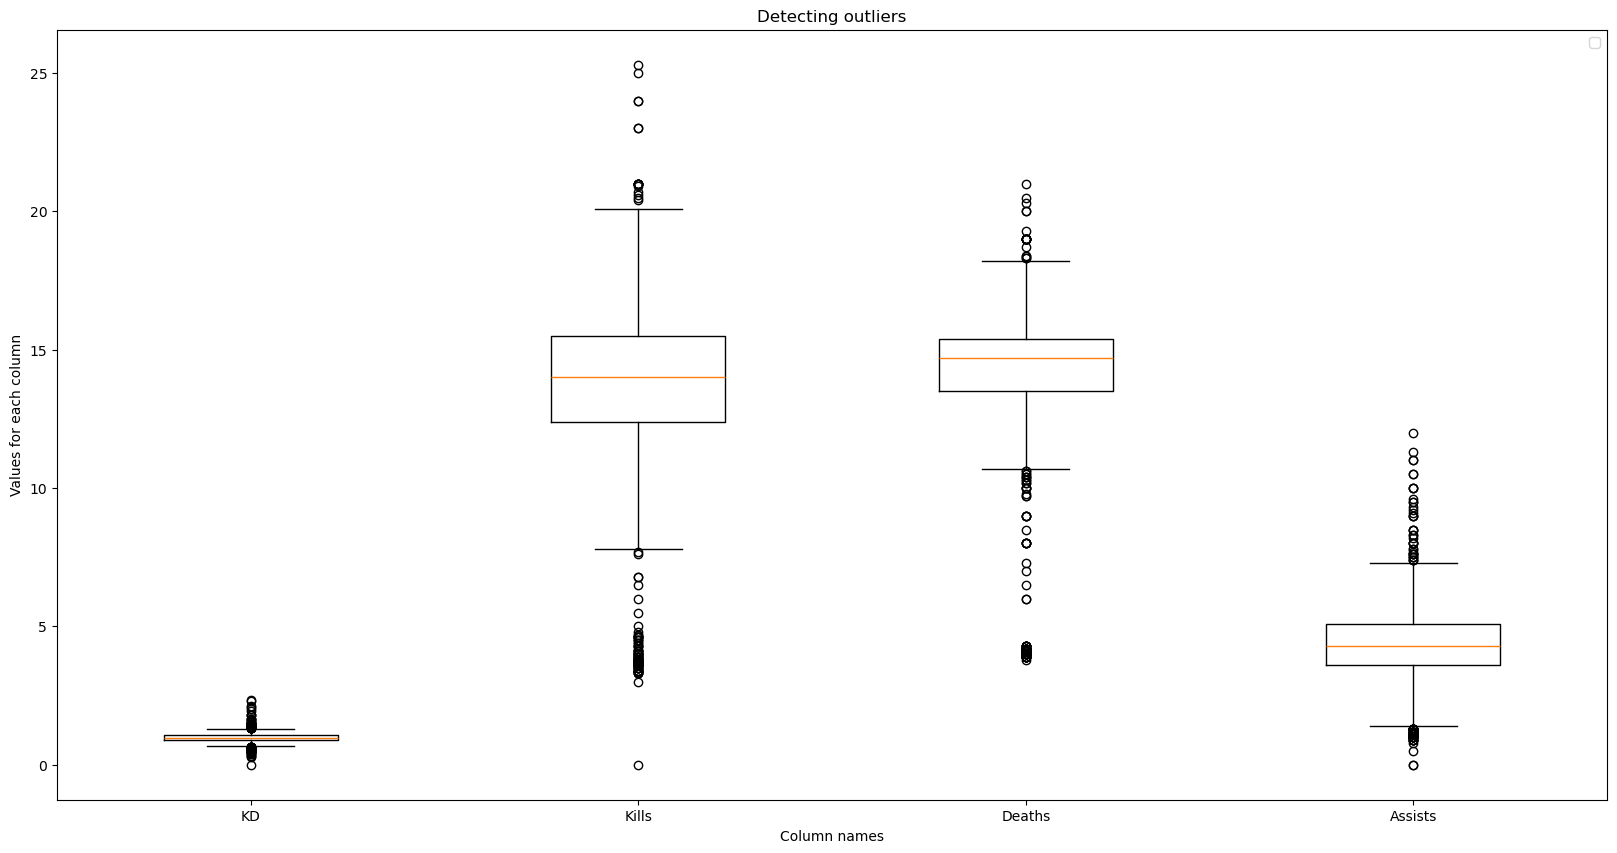

In [25]:
# setting a fixed randomnes
np.random.seed(385)

# defining how big the plot is gonna be
fig = plt.figure(figsize =(20, 10))

# titles and axis labels
plt.xlabel("Column names")
plt.ylabel("Values for each column")
plt.title("Detecting outliers")

plt.legend()

# plot box plot with data as input- 
# data is this one: df_nocol[['KD', 'Kills', 'Deaths', 'Assists', 'Win_Rate_Binary']]
plt.boxplot(df_nocol[['KD', 'Kills', 'Deaths', 'Assists']])

# after the plot is made, I change the x-axis names
# current names: [1, 2, 3, 4, 5], 
# new names: ['KD', 'Kills', 'Deaths', 'Assists', 'Win_Rate_Binary']
plt.xticks([1, 2, 3,4], ['KD', 'Kills', 'Deaths', 'Assists'])

## Statistical summary of the data

In [27]:
df_nocol[['KD', 'Kills', 'Deaths', 'Assists']].describe()

,KD,Kills,Deaths,Assists
count,1782.000000,1782.000000,1782.000000,1782.000000
mean,0.978171,13.641414,14.008586,4.363805
std,0.173384,3.304699,2.809239,1.493801
min,0.000000,0.000000,3.800000,0.000000
25%,0.900000,12.400000,13.500000,3.600000
50%,0.970000,14.000000,14.700000,4.300000
75%,1.060000,15.500000,15.400000,5.100000
max,2.330000,25.300000,21.000000,12.000000


## Histograms

In [29]:
df_nocol.columns

Index(['Agent Name', 'KD', 'Kills', 'Deaths', 'Assists', 'map_name',
       'Win_Rate_Binary'],
      dtype='object')

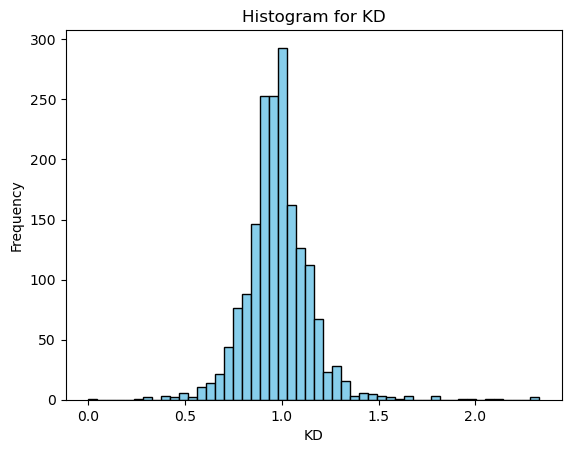

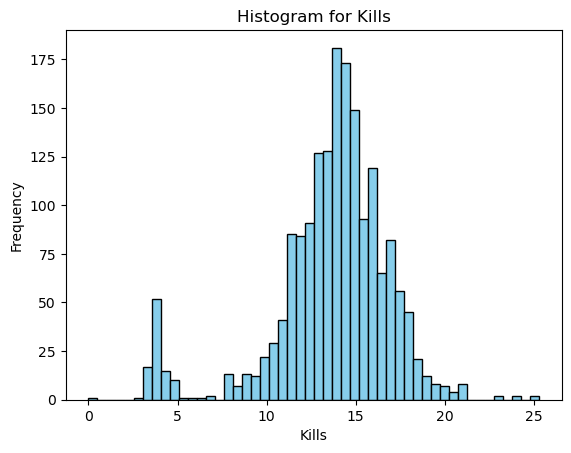

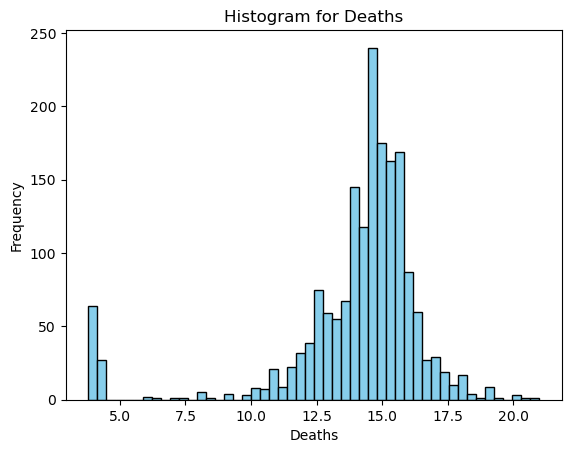

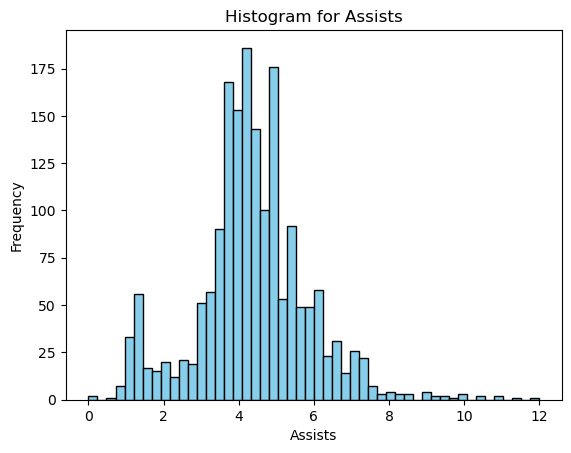

In [30]:
# df_nocol
for i in ['KD', 'Kills', 'Deaths', 'Assists']:

    # defining how big the plot is gonna be
    # fig = plt.figure(figsize =(500, 20))
    
    # Plotting a basic histogram
    plt.hist(df_nocol[i], bins=50, color='skyblue', edgecolor='black')
     
    # Adding labels and title
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {i}')
     
    # Display the plot
    plt.show()

## Correlation Matrix

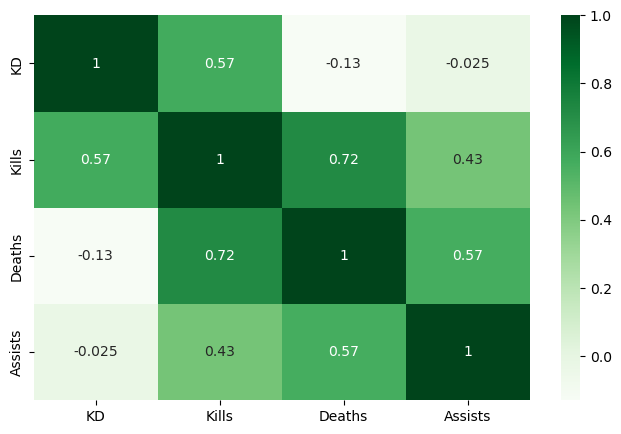

In [32]:
df_corr = df_nocol[['KD', 'Kills', 'Deaths', 'Assists']]
corr = df_corr.corr()

corr

plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

# Feature Selection

## Scatterplot matrix
KD, Kills and Death works good to seperate our data, they are important variables

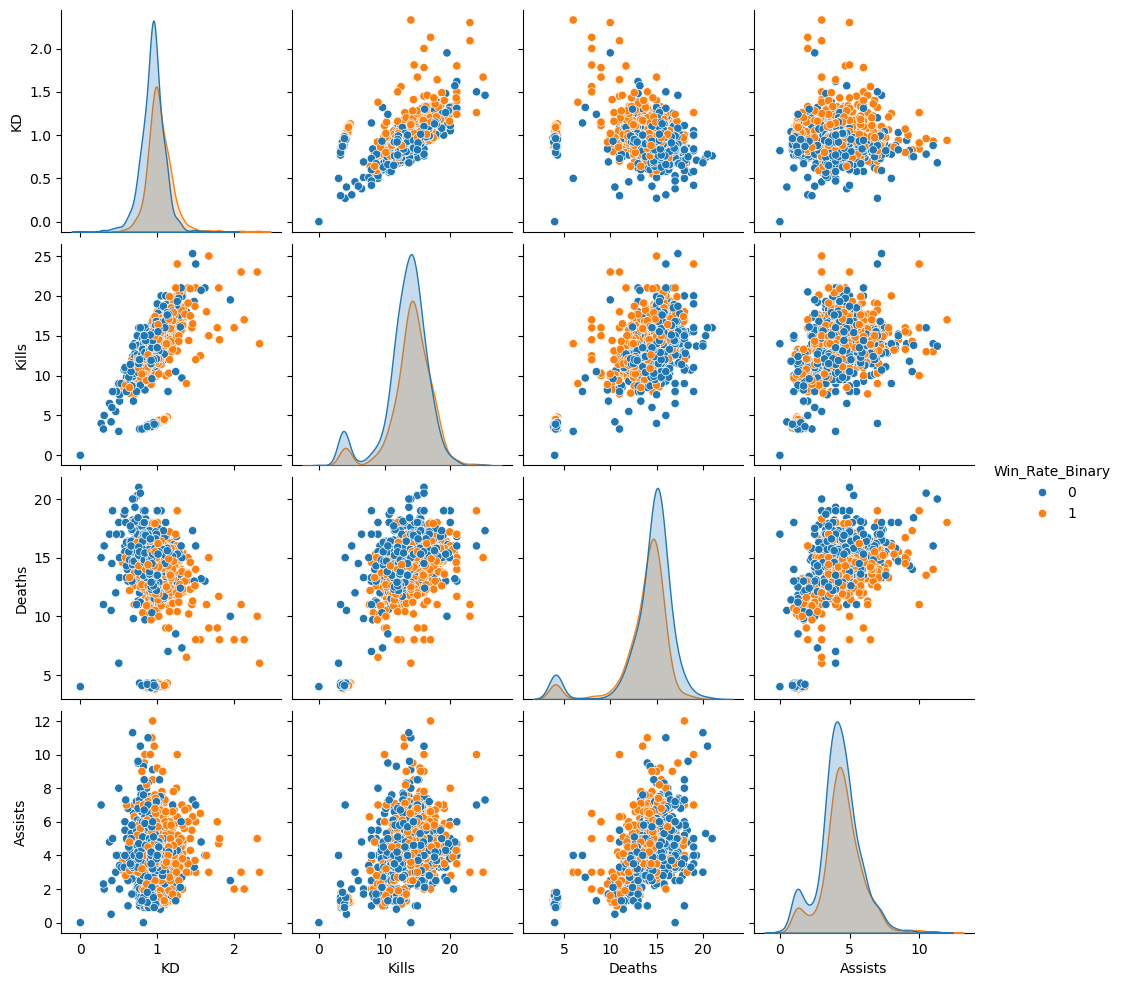

In [35]:
df_scatter = df_nocol[['KD', 'Kills', 'Deaths', 'Assists', 'Win_Rate_Binary']]

# Create the scatter plot matrix
sns.pairplot(df_scatter, hue="Win_Rate_Binary")

**We could use one hot encoding, but for preliminary results, we will just drop the categorical columns**

In [37]:
df_nocol = df_nocol[['KD', 'Kills', 'Deaths', 'Assists', 'Win_Rate_Binary']]

# Logistic Regression Model

## Train test split
- we split the dataframe into X and y matrix
    - X has all the columns except 'Win_Rate_Binary'
    - y has only 'Win_Rate_Binary'
- we split the X and y matrix into further splits as testing data and training data
    - X_train as 66% of X matrix while X_test as 33% of the X matrix
    - y_train as 66% of y matrix while y_test as 33% of the y matrix

In [40]:
# Seperating independant variables
X = df_nocol[['KD', 'Kills', 'Deaths', 'Assists']]

# Only dependant variable
y = df_nocol[['Win_Rate_Binary']]

# splitting data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=34566547)

# fitting our LR model
clf = LogisticRegression(random_state=34566547).fit(X_train, y_train)

## Making predictions on training data

In [42]:
# Predicting on training data
Predicted_Win_Rate_Binary = clf.predict(X_train)

# Making probability column
Proba_Win_Rate_Binary = clf.predict_proba(X_train)

**This part is just to explain what we did above**

In [44]:
# Putting back the dependant variable to the training data
X_train['Win_Rate_Binary'] = y_train

# creating a new column as predictions made by our model
X_train['Predicted_Win_Rate_Binary'] = Predicted_Win_Rate_Binary

# This has probability of our predictions by our model
Proba_Win_Rate_Binary[:,0]

# Creating a new column with probability of our predictions
X_train['Proba_Win_Rate_Binary'] = Proba_Win_Rate_Binary[:,1]

X_train

,KD,Kills,Deaths,Assists,Win_Rate_Binary,Predicted_Win_Rate_Binary,Proba_Win_Rate_Binary
1104,0.91,14.3,15.7,4.6,1,0,0.312342
330,0.98,14.5,14.8,4.4,0,0,0.389422
328,1.28,18.9,14.7,3.9,1,1,0.633050
1300,0.84,16.0,19.0,3.5,0,0,0.125813
1145,0.74,11.3,15.3,6.1,0,0,0.279700
...,...,...,...,...,...,...,...
952,0.95,14.2,14.9,5.0,0,0,0.403252
807,0.89,14.1,15.9,4.0,0,0,0.252320
873,1.13,14.3,12.6,4.3,1,1,0.584193
953,0.76,11.3,14.8,3.9,0,0,0.197592


## Confusion Matrix

In [46]:
cm = confusion_matrix(X_train['Win_Rate_Binary'], 
                 X_train['Predicted_Win_Rate_Binary'])

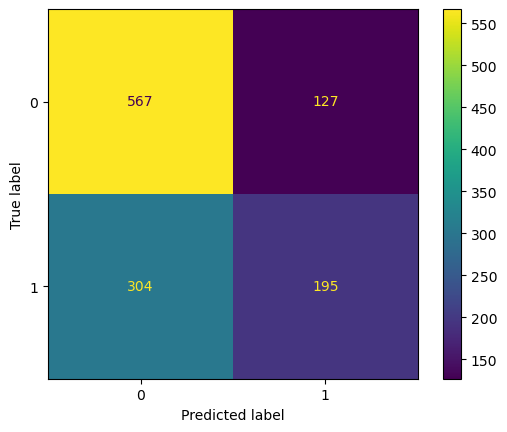

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

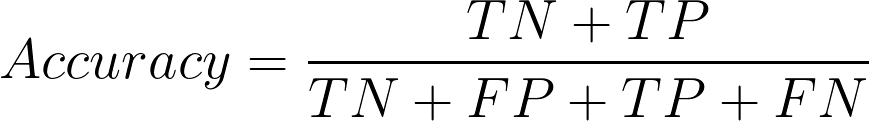

In [49]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

In [50]:
Acc = (TN+TP)/(TN+FP+TP+FN)
print(np.round(Acc*100, 2), '%')

train_base_lr = np.round(Acc*100, 2)

63.87 %


> 64% accuracy on training data

## Making predictions on test data

In [53]:
# Predicting on test data
Predicted_Win_Rate_Binary = clf.predict(X_test)

In [54]:
# Making probability column
Proba_Win_Rate_Binary = clf.predict_proba(X_test)

In [55]:
# putting back the dependant variable to the training data
X_test['Win_Rate_Binary'] = y_test

In [56]:
# creating a new column as predictions made by our model
X_test['Predicted_Win_Rate_Binary'] = Predicted_Win_Rate_Binary

In [57]:
# Creating a new column with probability of our predictions
X_test['Proba_Win_Rate_Binary'] = Proba_Win_Rate_Binary[:,1]

In [58]:
X_test

,KD,Kills,Deaths,Assists,Win_Rate_Binary,Predicted_Win_Rate_Binary,Proba_Win_Rate_Binary
1531,1.00,13.4,13.4,5.7,0,1,0.549198
1091,0.91,10.0,11.0,10.0,1,1,0.819315
1116,1.07,15.9,14.9,5.0,0,1,0.509715
1196,1.11,13.9,12.6,3.4,0,0,0.495863
1381,1.02,13.7,13.4,4.1,0,0,0.452000
...,...,...,...,...,...,...,...
1068,0.67,8.8,13.1,2.6,0,0,0.145230
1599,1.12,17.6,15.8,5.8,1,1,0.585231
1161,1.11,15.3,13.8,3.7,0,0,0.485975
1182,1.03,4.3,4.2,1.4,1,1,0.566250


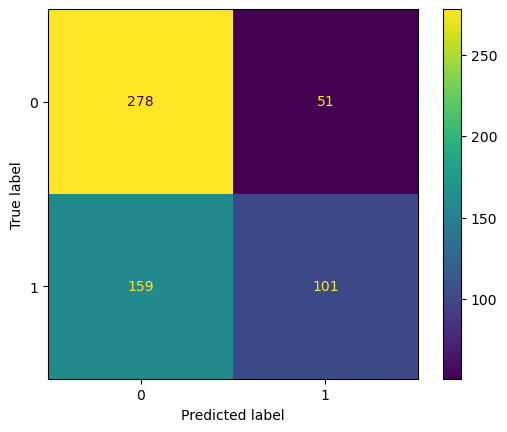

In [59]:
cm = confusion_matrix(X_test['Win_Rate_Binary'], 
                      X_test['Predicted_Win_Rate_Binary'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [60]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

Acc = (TN+TP)/(TN+FP+TP+FN)
print(np.round(Acc*100, 2), '%')

test_base_lr = np.round(Acc*100, 2)

64.35 %


> 64% on test data

# Iteration -2 for Prediction Model

In [62]:
df.head(3)

,Agent Name,KD,Kills,Deaths,Assists,Pick Rate,ACS,First Blood,Num Matches,map_name,Win_Rate_Binary
0,Jett,1.14,17.6,15.4,4.0,0.156,248.0,0.181,32946.0,all,1
1,Reyna,1.17,18.1,15.5,4.2,0.155,256.0,0.164,32844.0,all,1
2,Sage,0.96,13.9,14.5,4.6,0.124,195.0,0.120,26316.0,all,1


# Missing Values

In [64]:
# checking missing values
missing_values = df.isnull().sum()

print(missing_values)

Agent Name          0
KD                  0
Kills               0
Deaths              0
Assists             0
Pick Rate          45
ACS                45
First Blood        45
Num Matches        45
map_name            0
Win_Rate_Binary     0
dtype: int64


In [65]:
# Filling missing vals with median
for i in [ 'KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS','First Blood', 'Num Matches']:
    df[i]=df[i].fillna(df[i].median())

In [66]:
# checking missing values
missing_values = df.isnull().sum()

print(missing_values)

Agent Name         0
KD                 0
Kills              0
Deaths             0
Assists            0
Pick Rate          0
ACS                0
First Blood        0
Num Matches        0
map_name           0
Win_Rate_Binary    0
dtype: int64


## Standardize the data just for box plots

In [68]:
# define standard scaler
scaler = StandardScaler()
  
# transform numerical columns of our present data and created a new dataframe
scaled_df_nocol = scaler.fit_transform(df[['KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS','First Blood', 'Num Matches']])

In [69]:
scaled_df_nocol[0]

array([ 0.93362041,  1.19820204,  0.49543833, -0.24361138,  1.70126625,
        1.45789261,  0.80200534,  0.74559077])

In [70]:
# Converting the array to a pandas dataframe
scaled_df_nocol = pd.DataFrame(scaled_df_nocol)

# Renaming the column names to its original names
scaled_df_nocol = scaled_df_nocol.rename(columns={0: 'KD',
                                                  1: 'Kills',
                                                  2: 'Deaths',
                                                  3: 'Assists',
                                                 4: 'Pick Rate',
                                                 5: 'ACS',
                                                 6: 'First Blood',
                                                 7: 'Num Matches'})

scaled_df_nocol.head()

,KD,Kills,Deaths,Assists,Pick Rate,ACS,First Blood,Num Matches
0,0.933620,1.198202,0.495438,-0.243611,1.701266,1.457893,0.802005,0.745591
1,1.106695,1.349544,0.531045,-0.109687,1.681648,1.726267,0.491526,0.742558
2,-0.104829,0.078270,0.174977,0.158161,1.073484,-0.320088,-0.312068,0.548451
3,-0.277904,0.108538,0.388618,0.492972,0.426084,-0.185900,-0.239014,0.336146
4,0.414396,0.774444,0.495438,0.359048,0.269139,1.223065,0.363681,0.290652


([<matplotlib.axis.XTick at 0x1ec0493ef30>,
 [Text(1, 0, 'KD'),
  Text(2, 0, 'Kills'),
  Text(3, 0, 'Deaths'),
  Text(4, 0, 'Assists'),
  Text(5, 0, 'Pick Rate'),
  Text(6, 0, 'ACS'),
  Text(7, 0, 'First Blood'),
  Text(8, 0, 'Num Matches')])

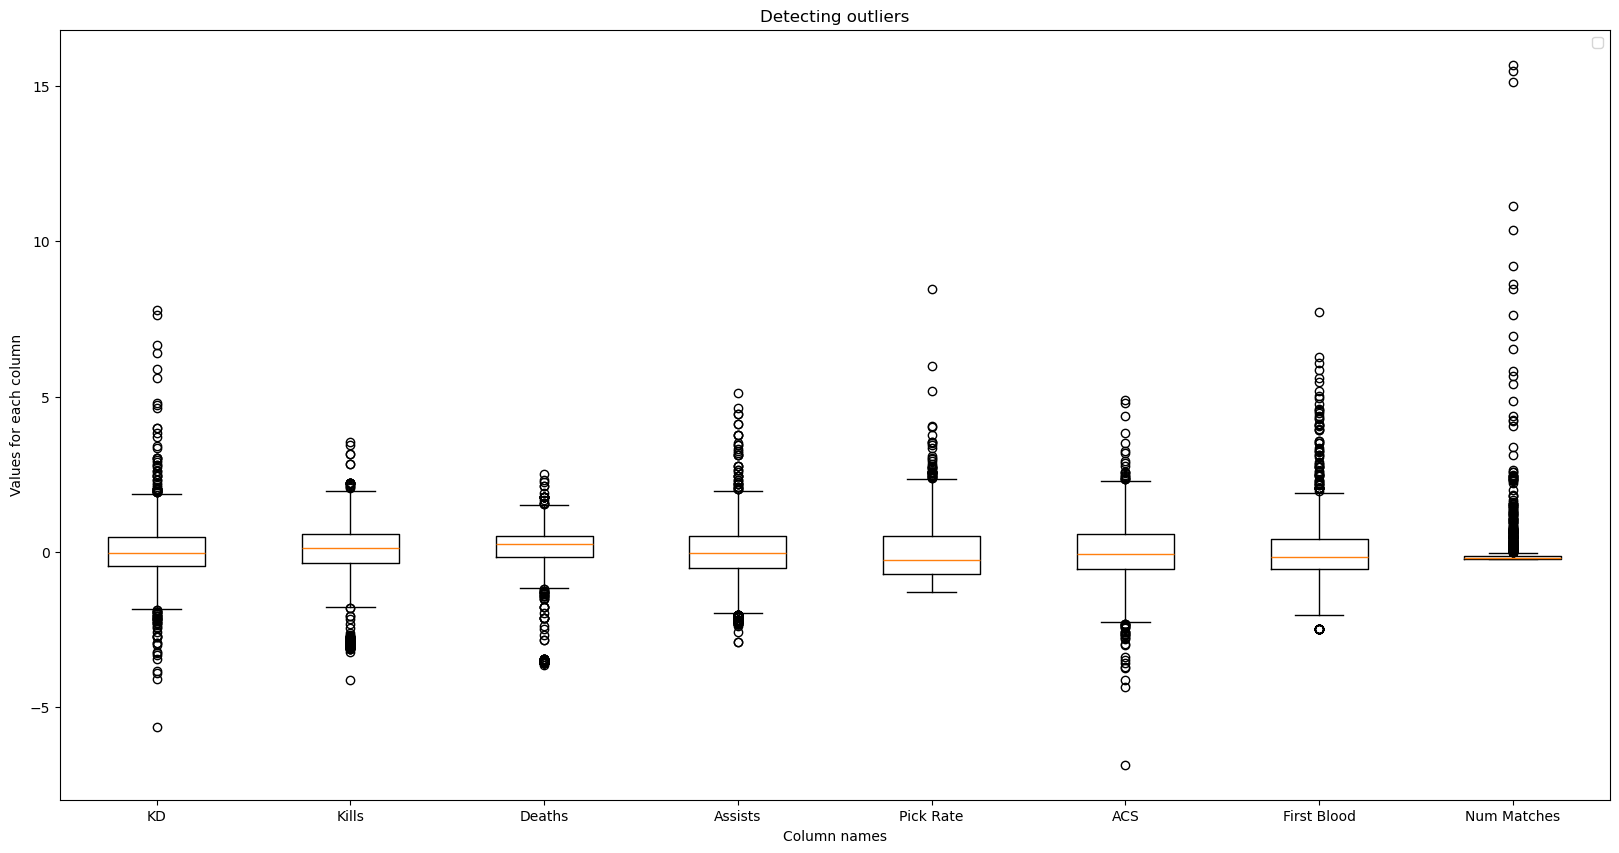

In [71]:
# setting a fixed randomnes
np.random.seed(385)

# defining how big the plot is gonna be
fig = plt.figure(figsize =(20, 10))

# titles and axis labels
plt.xlabel("Column names")
plt.ylabel("Values for each column")
plt.title("Detecting outliers")

plt.legend()

# plot box plot with data as input- 
# data is this one: df_nocol[['KD', 'Kills', 'Deaths', 'Assists', 'Win_Rate_Binary']]
plt.boxplot(scaled_df_nocol[[ 'KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS','First Blood', 'Num Matches']])

# after the plot is made, I change the x-axis names
# current names: [1, 2, 3, 4, 5], 
# new names: ['KD', 'Kills', 'Deaths', 'Assists', 'Win_Rate_Binary']
plt.xticks([1, 2, 3,4,5,6,7,8], [ 'KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS', 'First Blood', 'Num Matches'])

> Only observing outliers not treating them at first. If they cause overfitting then it will be treated cuz they might have important info.

In [73]:
df.head()

,Agent Name,KD,Kills,Deaths,Assists,Pick Rate,ACS,First Blood,Num Matches,map_name,Win_Rate_Binary
0,Jett,1.14,17.6,15.4,4.0,0.156,248.0,0.181,32946.0,all,1
1,Reyna,1.17,18.1,15.5,4.2,0.155,256.0,0.164,32844.0,all,1
2,Sage,0.96,13.9,14.5,4.6,0.124,195.0,0.120,26316.0,all,1
3,Omen,0.93,14.0,15.1,5.1,0.091,199.0,0.124,19176.0,all,0
4,Raze,1.05,16.2,15.4,4.9,0.083,241.0,0.157,17646.0,all,1


## Histograms and bar plots

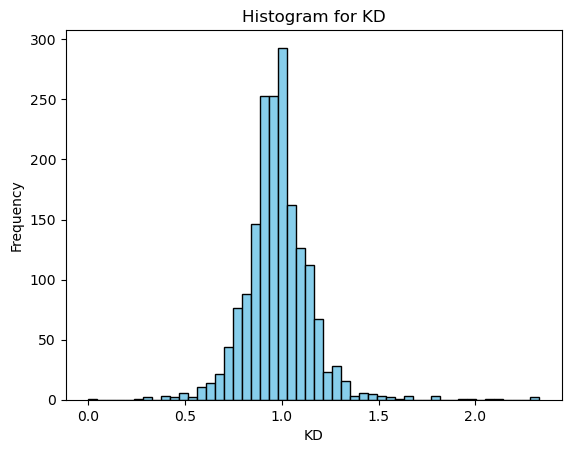

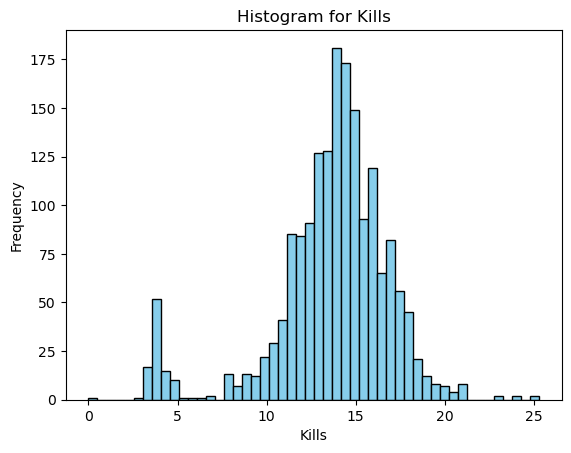

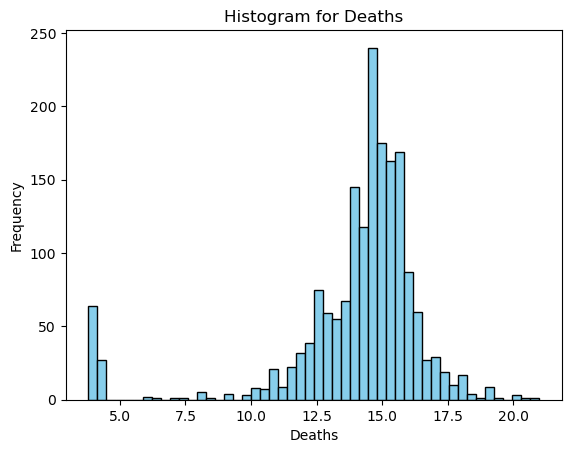

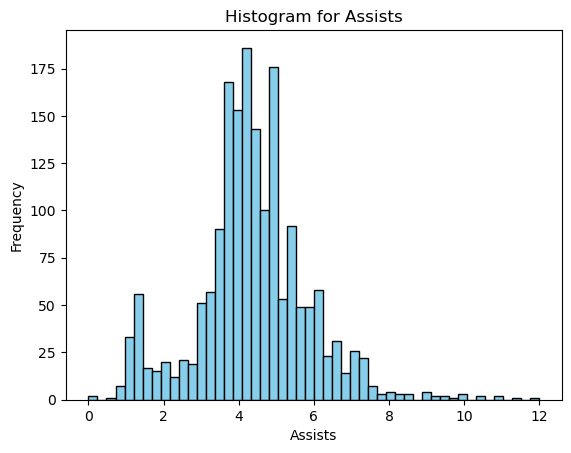

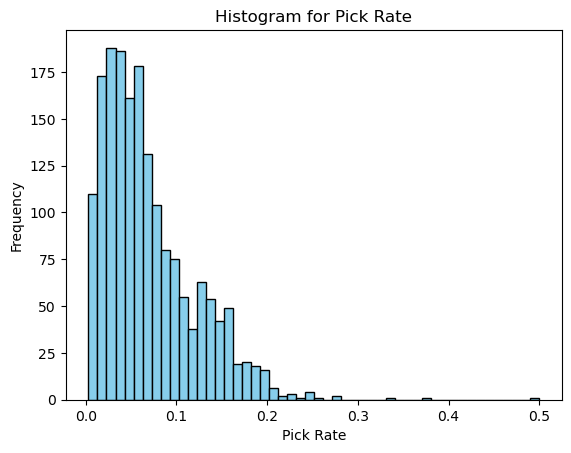

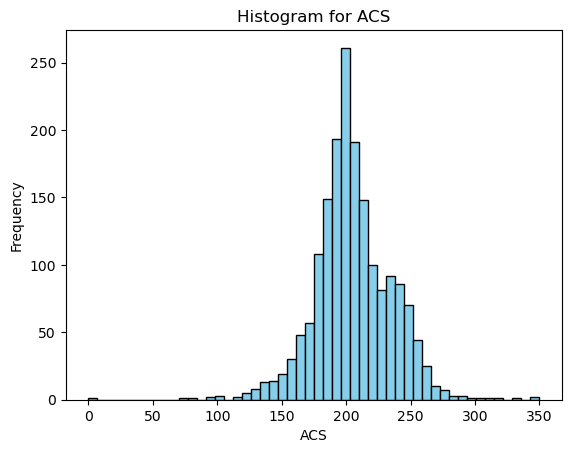

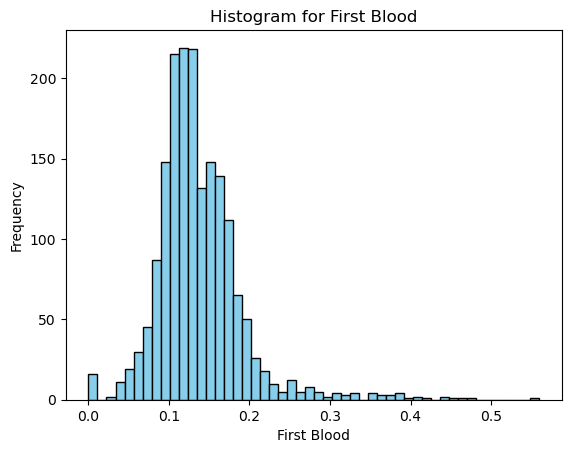

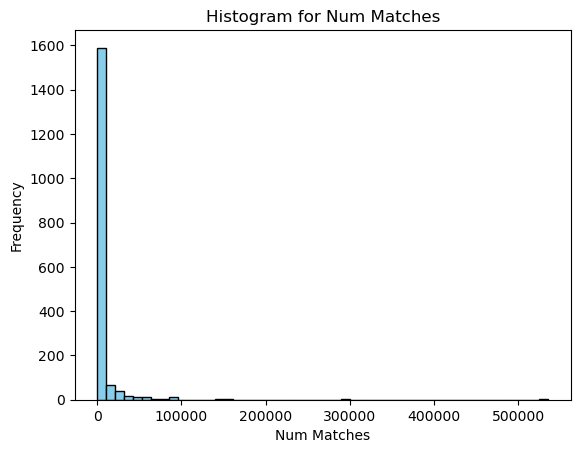

In [75]:
# df
for i in [ 'KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS','First Blood', 'Num Matches']:
    # Plotting a basic histogram
    plt.hist(df[i], bins=50, color='skyblue', edgecolor='black')
     
    # Adding labels and title
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for {i}')
     
    # Display the plot
    plt.show()

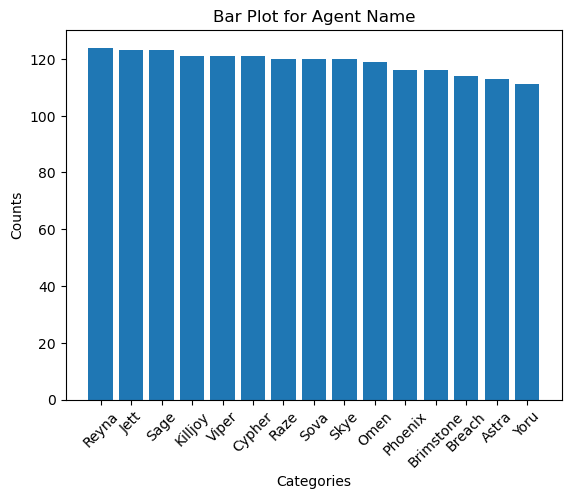

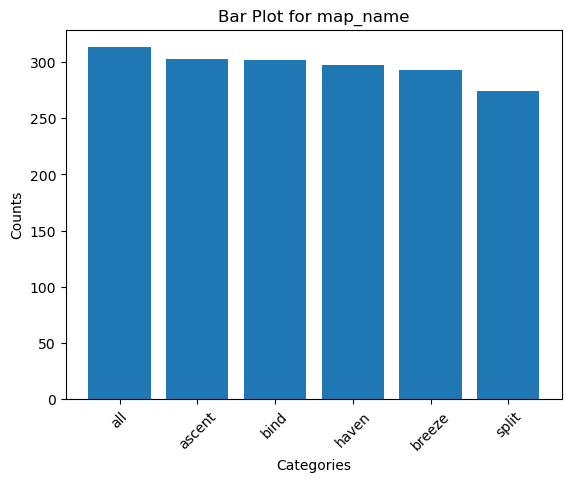

In [76]:
for i in ['Agent Name', 'map_name']:
    
    category = df[i].nunique()

    counts = []
    for j in range (category):
        #print(i)
        #print(df[i].value_counts()[i])
        counts.append(df[i].value_counts()[j])
        
    names = df[i].value_counts().index.tolist()
    
    # Bar plots
    # Sample data
    categories = names
    values = counts
    
    # Create the bar plot
    plt.bar(categories, values)
    
    # Add labels and title
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title(f'Bar Plot for {i}')
    
    # Rotate x-ticks by 45 degrees
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

The **Agent Name bar plot** shows that all agents are picked in nearly equal proportions (~110–120 times each). This indicates a balanced dataset where no single agent dominates, reducing the risk of bias in analyses involving agents.  

The **map_name bar plot** shows slightly more variation, with maps like Split having fewer matches (270) compared to others (~290–310). Still, the distribution remains relatively balanced, ensuring that most maps are well-represented and suitable for comparisons or modeling.  


## Correlation Matrix
If a value if btween -0.5 to 0.5, the value is mostlikely independant to each other. Anything beyond that may get concerning for our model.
- Deaths and kills are highly correlated
- ACS abd KD are high corr
- ACS kills are high corr

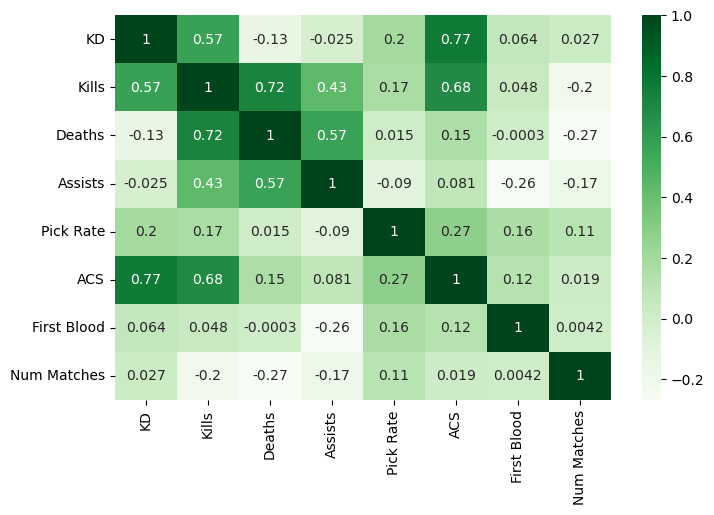

In [78]:
df_corr = df[['KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS','First Blood', 'Num Matches']]
corr = df_corr.corr()

corr

plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

# Feature Selection
## Scatterplot matrix
- Each variable individually can;t seperate the target variable

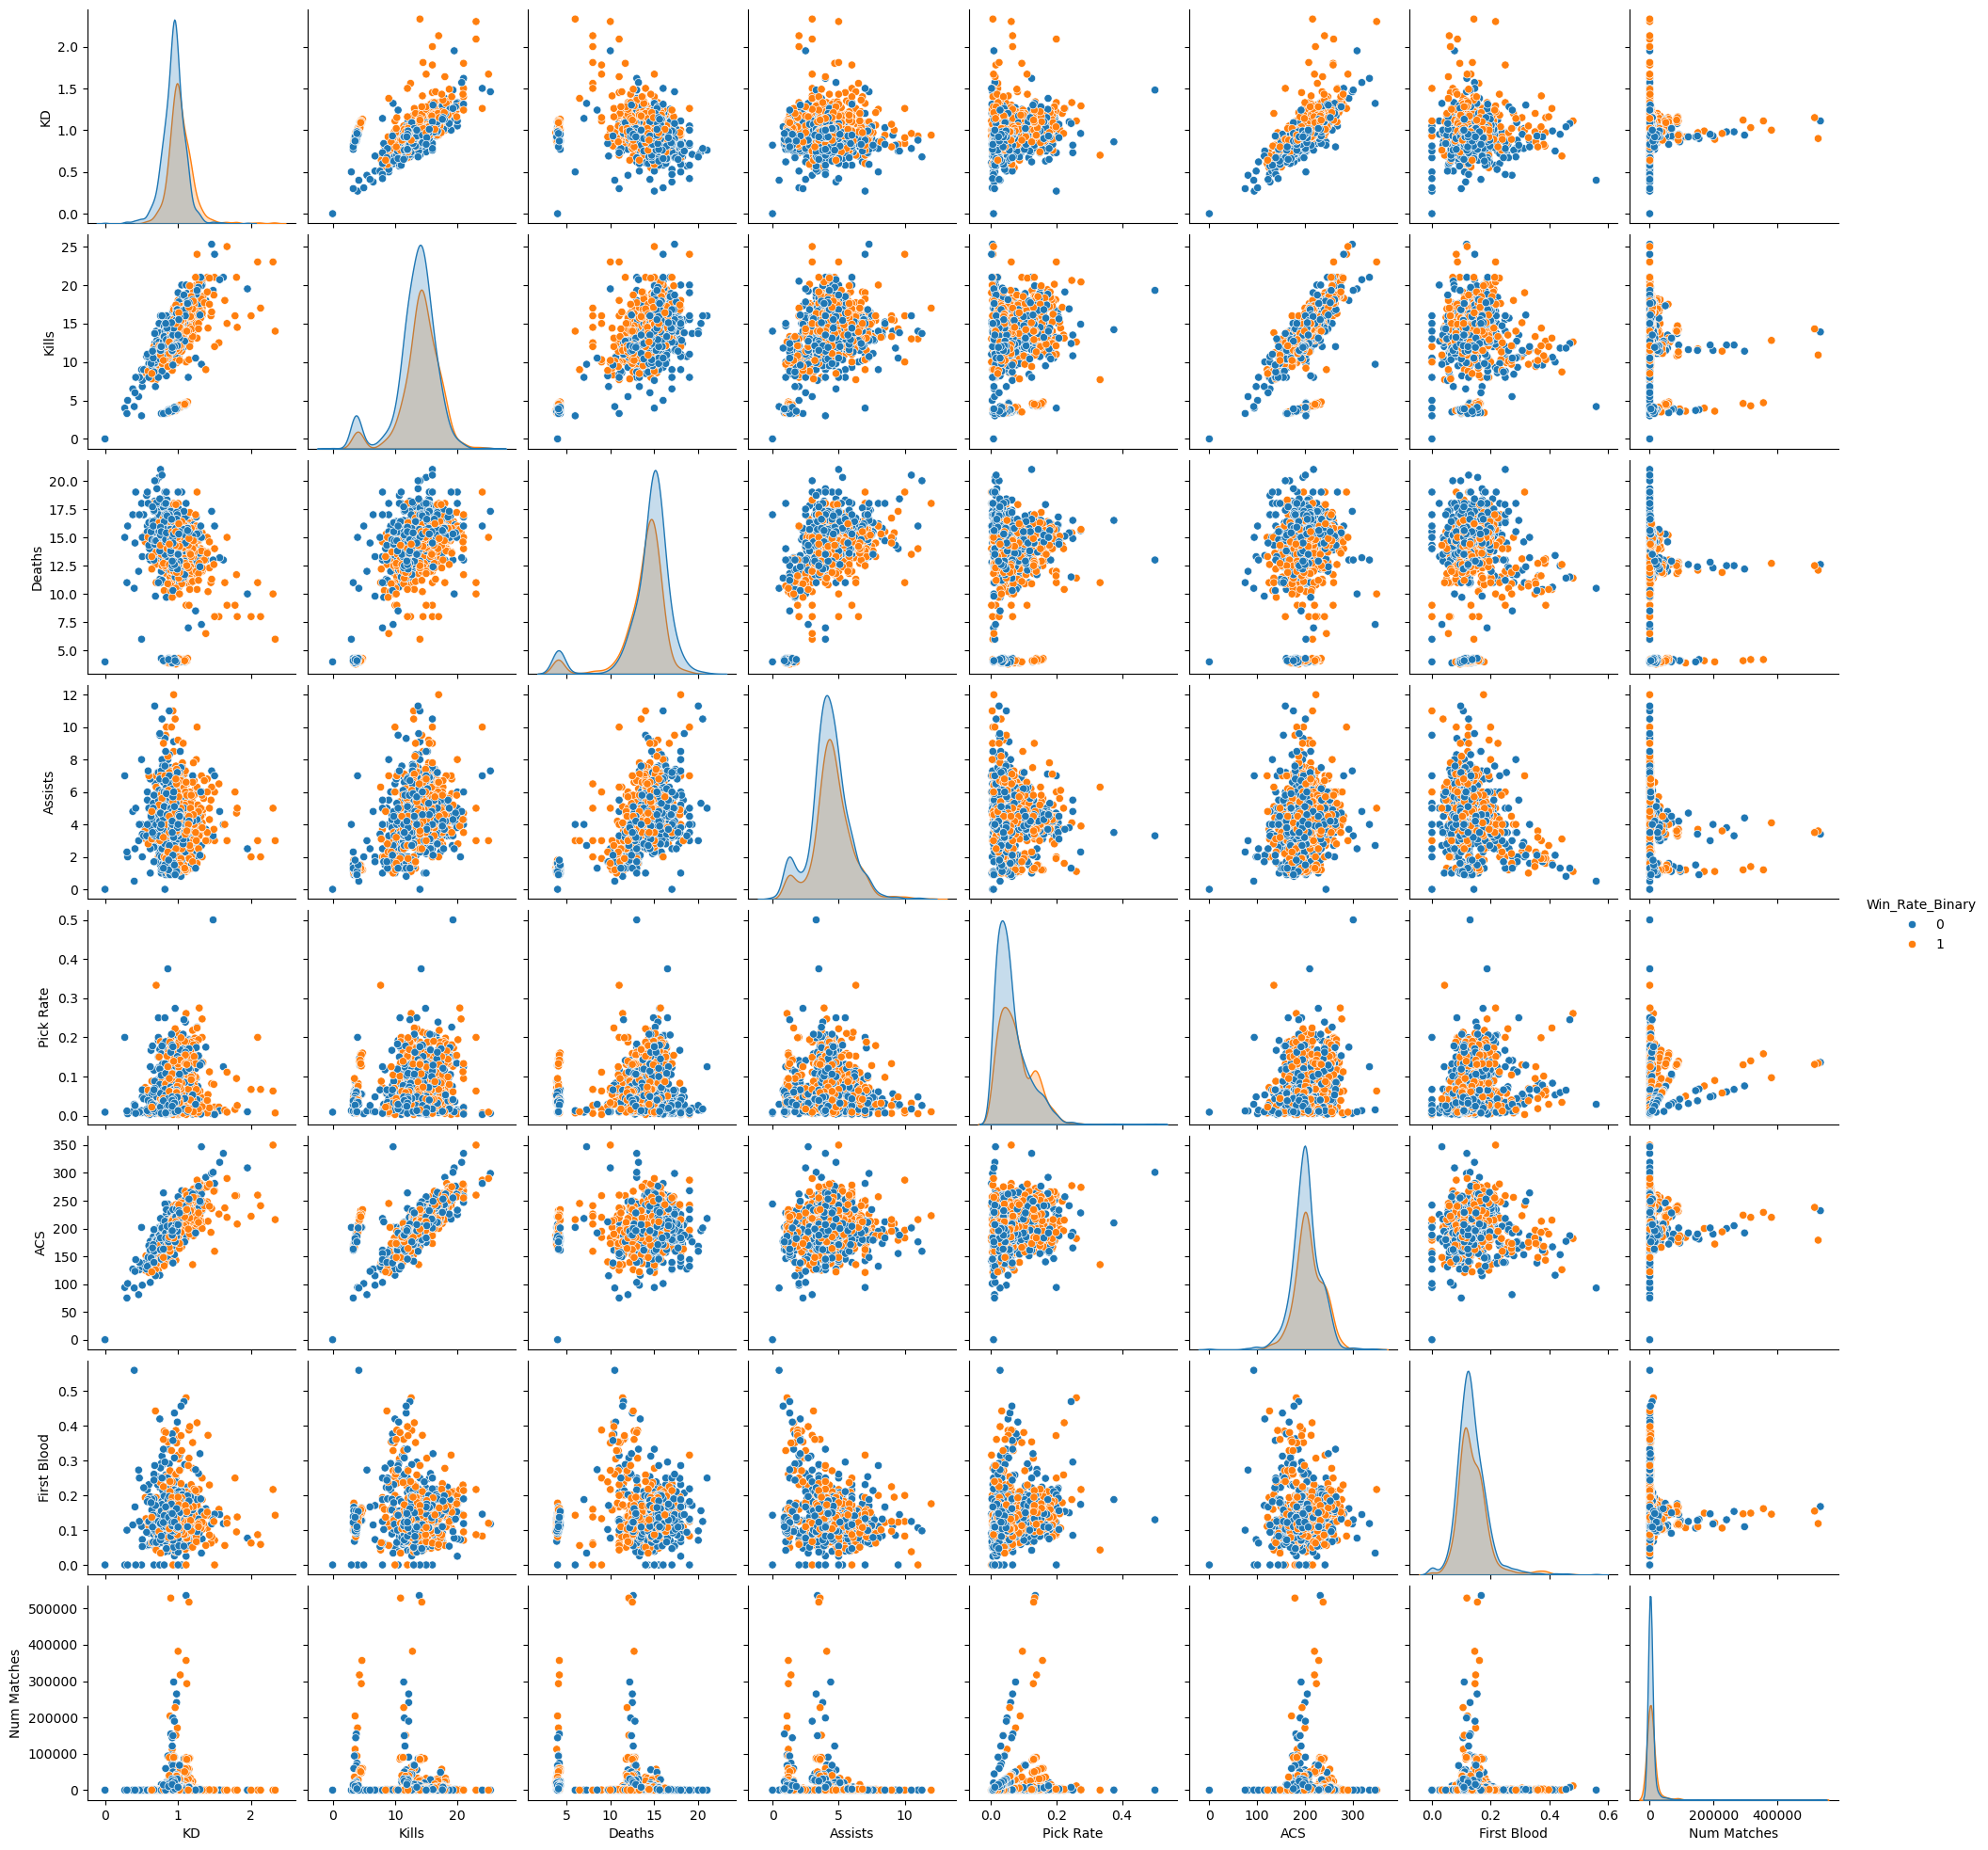

In [80]:
df_scatter = df[['KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS','First Blood', 'Num Matches', 'Win_Rate_Binary']]

# Create the scatter plot matrix
sns.pairplot(df_scatter, hue="Win_Rate_Binary")

> Separation matter, good separation means the factors are importanrt

### Looking at an individual scatterplot between two chosen variables
We could not find any seperation with two variables for our binary class.

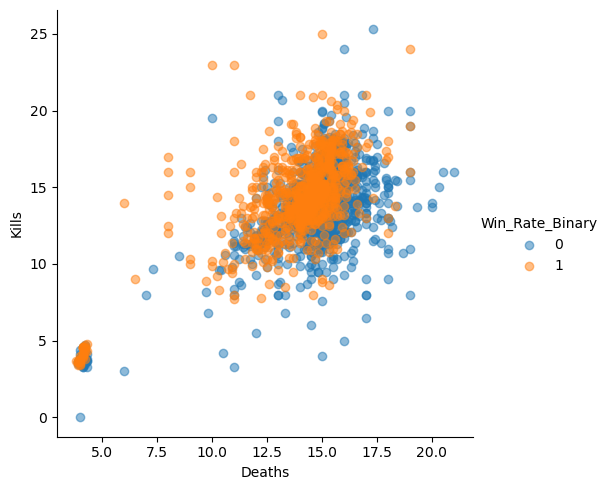

In [83]:
sns.lmplot(x='Deaths', y='Kills', data=df, hue='Win_Rate_Binary', fit_reg=False, scatter_kws={'alpha':0.5})

# Logistic Regression
## Train test split
- we split the dataframe into X and y matrix
    - X has all the columns except 'Win_Rate_Binary'
    - y has only 'Win_Rate_Binary'
- we split the X and y matrix into further splits as testing data and training data
    - X_train as 66% of X matrix while X_test as 33% of the X matrix
    - y_train as 66% of y matrix while y_test as 33% of the y matrix

In [85]:
df.columns

Index(['Agent Name', 'KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS',
       'First Blood', 'Num Matches', 'map_name', 'Win_Rate_Binary'],
      dtype='object')

In [86]:
# Seperating independant variables
X = df[['KD', 'Kills', 'Deaths', 'Assists', 'Pick Rate', 'ACS',
       'First Blood', 'Num Matches']]

# Only dependant variable
y = df[['Win_Rate_Binary']]

# splitting data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=34566547)



# hyperparameters
parameters = [{'penalty':['l1', 'l2', 'elasticnet']}, 
              {'C':[0.001,0.01,0.1,1,10,100,1000]},
             {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']},
             {'verbose':[0,1]}]

lr = LogisticRegression()  # defining our model

# performing grid search
grid = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

# fitting our LR model
clf = grid.fit(X_train, y_train)

In [87]:
clf

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2', 'elasticnet']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                         {'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                     'newton-cholesky', 'sag', 'saga']},
                         {'verbose': [0, 1]}],
             scoring='accuracy')

In [89]:
# Checking each epoch of grid search to look at the best parameters
pd.DataFrame.from_dict(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,param_solver,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000926,0.000656,0.000000,0.000000,l1,NaN,NaN,NaN,{'penalty': 'l1'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
1,0.025891,0.012348,0.003228,0.002061,l2,NaN,NaN,NaN,{'penalty': 'l2'},0.652720,0.606695,0.610879,0.626050,0.634454,0.626159,0.016653,8
2,0.001198,0.000399,0.000000,0.000000,elasticnet,NaN,NaN,NaN,{'penalty': 'elasticnet'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
3,0.024126,0.016688,0.004960,0.005597,NaN,0.001,NaN,NaN,{'C': 0.001},0.581590,0.606695,0.598326,0.600840,0.626050,0.602700,0.014349,14
4,0.016886,0.001540,0.003612,0.000796,NaN,0.010,NaN,NaN,{'C': 0.01},0.652720,0.610879,0.602510,0.617647,0.634454,0.623642,0.017932,13
5,0.033249,0.016842,0.004427,0.004242,NaN,0.100,NaN,NaN,{'C': 0.1},0.656904,0.623431,0.615063,0.617647,0.634454,0.629500,0.015240,6
6,0.017030,0.002017,0.003557,0.000781,NaN,1.000,NaN,NaN,{'C': 1},0.652720,0.606695,0.610879,0.626050,0.634454,0.626159,0.016653,8
7,0.018598,0.002015,0.003155,0.000944,NaN,10.000,NaN,NaN,{'C': 10},0.652720,0.610879,0.610879,0.630252,0.634454,0.627837,0.015773,7
8,0.038633,0.032658,0.006119,0.004404,NaN,100.000,NaN,NaN,{'C': 100},0.652720,0.648536,0.610879,0.642857,0.634454,0.637889,0.014828,4
9,0.033160,0.007000,0.007299,0.002459,NaN,1000.000,NaN,NaN,{'C': 1000},0.656904,0.644351,0.610879,0.630252,0.634454,0.635368,0.015305,5


# Making Predictions on Training Data

In [91]:
# Predicting on training data
Predicted_Win_Rate_Binary = clf.predict(X_train)

# Making probability column
Proba_Win_Rate_Binary = clf.predict_proba(X_train)

## This section is only to understand what happened above

In [93]:
# assigning the training data to this variable name
X_train = X_train

# putting back the dependant variable to the training data
X_train['Win_Rate_Binary'] = y_train

# creating a new column as predictions made by our model
X_train['Predicted_Win_Rate_Binary'] = Predicted_Win_Rate_Binary

# This has probability of our predictions by our model
Proba_Win_Rate_Binary[:,0]

# Creating a new column with probability of our predictions
X_train['Proba_Win_Rate_Binary'] = Proba_Win_Rate_Binary[:,1]

X_train

,KD,Kills,Deaths,Assists,Pick Rate,ACS,First Blood,Num Matches,Win_Rate_Binary,Predicted_Win_Rate_Binary,Proba_Win_Rate_Binary
1104,0.91,14.3,15.7,4.6,0.019,201.0,0.140,357.0,1,0,0.271870
330,0.98,14.5,14.8,4.4,0.119,197.0,0.095,3162.0,0,0,0.464708
328,1.28,18.9,14.7,3.9,0.150,264.0,0.164,3978.0,1,1,0.625684
1300,0.84,16.0,19.0,3.5,0.009,234.0,0.219,102.0,0,0,0.040347
1145,0.74,11.3,15.3,6.1,0.047,174.0,0.092,1122.0,0,0,0.225797
...,...,...,...,...,...,...,...,...,...,...,...
952,0.95,14.2,14.9,5.0,0.077,192.0,0.075,867.0,0,0,0.457487
807,0.89,14.1,15.9,4.0,0.047,199.0,0.171,1122.0,0,0,0.224868
873,1.13,14.3,12.6,4.3,0.009,192.0,0.089,561.0,1,1,0.731875
953,0.76,11.3,14.8,3.9,0.072,170.0,0.133,816.0,0,0,0.199756


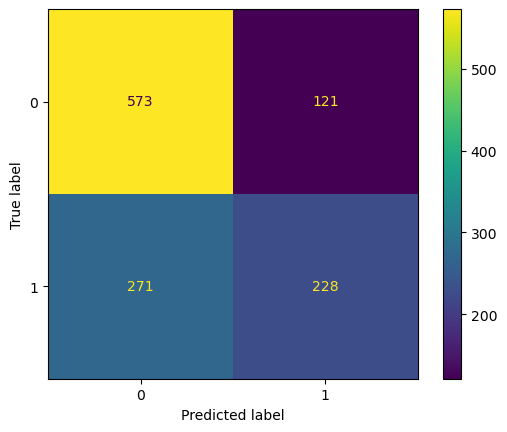

In [94]:
cm = confusion_matrix(X_train['Win_Rate_Binary'], 
                      X_train['Predicted_Win_Rate_Binary'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [95]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

Acc = (TN+TP)/(TN+FP+TP+FN)
print(np.round(Acc*100, 2), '%')

train_tuned_lr = np.round(Acc*100, 2)

67.14 %


# Test accuracy (unknown data accuracy)

In [97]:
X_test.head()

,KD,Kills,Deaths,Assists,Pick Rate,ACS,First Blood,Num Matches
1531,1.00,13.4,13.4,5.7,0.049,206.0,0.075,1275.0
1091,0.91,10.0,11.0,10.0,0.013,183.0,0.200,51.0
1116,1.07,15.9,14.9,5.0,0.035,219.0,0.142,408.0
1196,1.11,13.9,12.6,3.4,0.136,232.0,0.168,535500.0
1381,1.02,13.7,13.4,4.1,0.062,187.0,0.115,357.0


In [98]:
# Predicting on training data
Predicted_Win_Rate_Binary = clf.predict(X_test)

# Making probability column
Proba_Win_Rate_Binary = clf.predict_proba(X_test)

In [99]:
# assigning the training data to this variable name
X_test = X_test

# putting back the dependant variable to the training data
X_test['Win_Rate_Binary'] = y_test

# creating a new column as predictions made by our model
X_test['Predicted_Win_Rate_Binary'] = Predicted_Win_Rate_Binary

# This has probability of our predictions by our model
Proba_Win_Rate_Binary[:,0]

# Creating a new column with probability of our predictions
X_test['Proba_Win_Rate_Binary'] = Proba_Win_Rate_Binary[:,1]

X_test.head()

,KD,Kills,Deaths,Assists,Pick Rate,ACS,First Blood,Num Matches,Win_Rate_Binary,Predicted_Win_Rate_Binary,Proba_Win_Rate_Binary
1531,1.00,13.4,13.4,5.7,0.049,206.0,0.075,1275.0,0,1,0.515316
1091,0.91,10.0,11.0,10.0,0.013,183.0,0.200,51.0,1,1,0.834435
1116,1.07,15.9,14.9,5.0,0.035,219.0,0.142,408.0,0,1,0.512375
1196,1.11,13.9,12.6,3.4,0.136,232.0,0.168,535500.0,0,1,0.936532
1381,1.02,13.7,13.4,4.1,0.062,187.0,0.115,357.0,0,1,0.590594


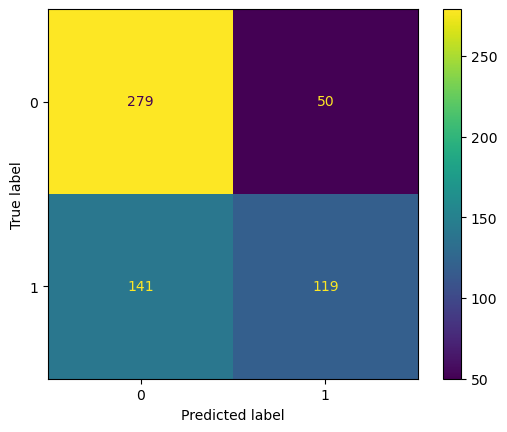

In [100]:
cm = confusion_matrix(X_test['Win_Rate_Binary'], 
                      X_test['Predicted_Win_Rate_Binary'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [101]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

Acc = (TN+TP)/(TN+FP+TP+FN)
print(np.round(Acc*100, 2), '%')
test_tuned_lr = np.round(Acc*100, 2)

67.57 %


> Final test prediction accuracy was found to be 68%

# Comparing baseline model and final model

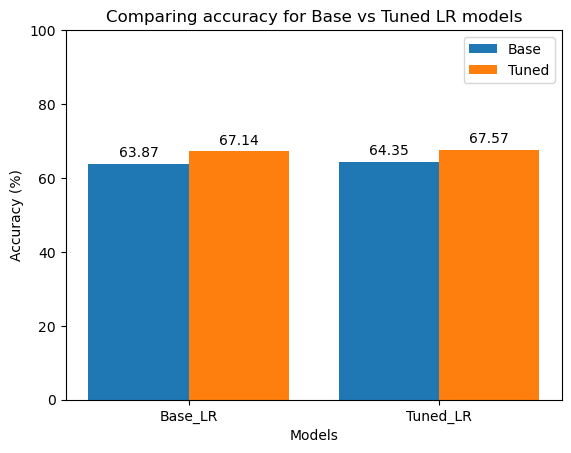

In [181]:
# Example variable names (fix base values)
X = ['Base_LR', 'Tuned_LR'] 
base = [train_base_lr, test_base_lr]   # Train, Test for base model
tuned = [train_tuned_lr, test_tuned_lr]  # Train, Test for tuned model

X_axis = np.arange(len(X))

# Plot bars
bars1 = plt.bar(X_axis - 0.2, base, 0.4, label='Base')
bars2 = plt.bar(X_axis + 0.2, tuned, 0.4, label='Tuned')

# Add labels
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Comparing accuracy for Base vs Tuned LR models")
plt.legend()

# Add values on top of bars
for bar in bars1 + bars2:
    plt.text(
        bar.get_x() + bar.get_width()/2,  # X position (center of bar)
        bar.get_height() + 1,             # Y position slightly above bar
        f'{bar.get_height():.2f}',        # Format with 2 decimals
        ha='center', va='bottom'
    )

plt.show()

> The bar chart shows that the **Tuned Logistic Regression (LR) model** achieves higher accuracy than the **Base LR model** for both train and test sets.